### Assumptions:

- Spherical Earth
- Spherical Orbit
- No atmospheric effects
- 365.0 days per year

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from matplotlib import cm

# Monte Carlo Simulation
### (Which turns out to be too slow)

In [221]:
axis_theta = np.linspace(0, 2*np.pi, num=512)
axis_phi = np.linspace(0, np.pi, num=256)

In [222]:
surface = np.ones((256,512,3))
surface[...,0], surface[...,1] = np.meshgrid(axis_theta, axis_phi)

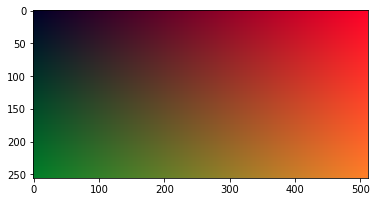

In [223]:
plt.imshow(surface/(2*np.pi));

In [6]:
def spher2cart(vector):
    '''
    Converts unit vector from spherical to cartesian coords
    '''
    theta, phi = vector[...,0], vector[...,1]
    z = np.cos(phi)
    r = np.sin(phi)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return np.stack([x, y, z], axis=-1)

In [7]:
def calc_light(surface, sun_angle, tilt=None):
    '''
    calculates light hitting a spherical surface from specified angle
    assumes surface is specified in spherical coords
    optionally applies cartesian rotation to the surface
    '''
    cartesian_surface = spher2cart(surface)
    cartesian_sun = spher2cart(sun_angle)
    
    if tilt is not None:
        cartesian_surface = cartesian_surface@tilt
    
    return np.clip(cartesian_surface@cartesian_sun, 0, 1)

In [8]:
SUN_ANGLE = np.array((np.pi/2,np.pi/2))

In [9]:
sun_angle_cart = spher2cart(SUN_ANGLE.reshape((1,2)))
sun_angle_cart, sun_angle_cart.shape

(array([[  6.12323400e-17,   1.00000000e+00,   6.12323400e-17]]), (1, 3))

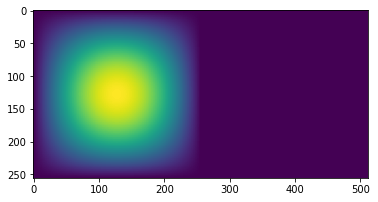

In [10]:
plt.imshow(calc_light(surface, SUN_ANGLE));

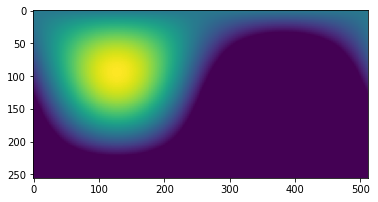

In [11]:
ξ = np.deg2rad(23.6)
earth_tilt = np.array([[1, 0, 0],
                       [0, np.cos(ξ), -np.sin(ξ)],
                       [0, np.sin(ξ), np.cos(ξ)]])

plt.imshow(calc_light(surface, SUN_ANGLE, earth_tilt));

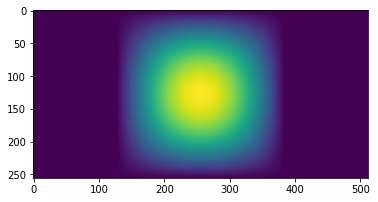

In [12]:
ϕ = np.deg2rad(90)
earth_spin = np.array([[np.cos(ϕ), -np.sin(ϕ), 0],
                       [np.sin(ϕ), np.cos(ϕ), 0],
                       [0, 0, 1]])

plt.imshow(calc_light(surface, SUN_ANGLE, earth_spin));

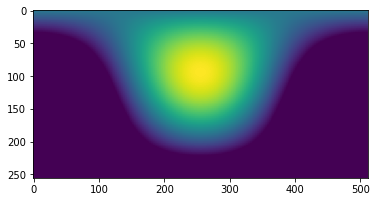

In [13]:
earth_tilt_and_spin = earth_spin@earth_tilt

plt.imshow(calc_light(surface, SUN_ANGLE, earth_tilt_and_spin));

In [14]:
def tilt_from_angle(angle_deg):
    ξ = np.deg2rad(angle_deg)
    return np.array([[1, 0, 0],
                     [0, np.cos(ξ), -np.sin(ξ)],
                     [0, np.sin(ξ), np.cos(ξ)]])

def accumulate_light(surface, sun_angle, tilt, n_steps):

    tilt_matrix = tilt_from_angle(tilt)
    
    accumulator = np.zeros((n_steps, surface.shape[0], surface.shape[1]))
    
    orbital_periods = np.random.uniform(0, 4*np.pi, size=n_steps)
    spin_periods = np.random.uniform(0, 4*np.pi, size=n_steps)
    
    for n in tqdm(range(n_steps)):
        accumulator[n] = calc_light(surface + [spin_periods[n], 0, 0],
                                    sun_angle + [orbital_periods[n], 0],
                                    tilt_matrix)
        
    print('Simulation completed with {} samples.'.format(n_steps))
    return accumulator

In [15]:
test = accumulate_light(surface, SUN_ANGLE, 23, 100)

100%|██████████| 100/100 [00:01<00:00, 56.40it/s]

Simulation completed with 100 samples.


In [16]:
test_mean = test.mean(axis=0)

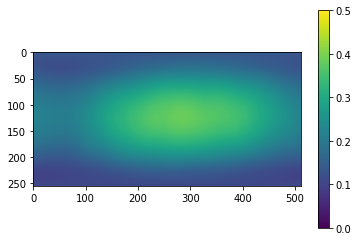

In [17]:
plt.imshow(test_mean, vmin=0, vmax=0.5)
plt.colorbar();

In [18]:
test_var = test.var(axis=0)

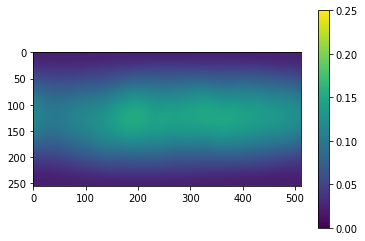

In [19]:
plt.imshow(test_var, vmin=0, vmax=0.25)
plt.colorbar();

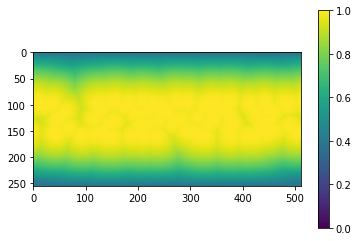

In [20]:
plt.imshow(test.max(axis=0), vmin=0, vmax=1)
plt.colorbar();

# Tensorflow implementation with unformly-spaced samples

In [21]:
import tensorflow as tf

In [311]:
def tf_spher2cart(vector):
    '''
    Converts unit vector from spherical to cartesian coords
    '''
    theta, phi = vector[...,0], vector[...,1]
    z = tf.cos(phi)
    r = tf.sin(phi)
    x = r*tf.cos(theta)
    y = r*tf.sin(theta)
    return tf.stack([x, y, z], axis=-1)

def tf_calc_light(surface, sun_angle, rotation):
    '''
    calculates light hitting a spherical surface from specified angle
    assumes surface is specified in spherical coords
    applies cartesian rotation to the surface
    '''

    cartesian_surface = tf_spher2cart(surface)
    cartesian_sun = tf_spher2cart(sun_angle)
    
    rotated_surface = tf.einsum('ijk,nkl->nijl', cartesian_surface, rotation)
    surface_alignment = tf.einsum('mijk,mk->mij', rotated_surface, cartesian_sun)
    
    return tf.clip_by_value(surface_alignment, 0, 1)

def tf_running_accumulator(light_samples, samples_per_day):
    #
    # TODO: this really should just use 1d convolution for far more simplicity
    # and probably speed, but doing it this way is a nice learning exercise
    #
    n = samples_per_day
    s = light_samples
    i = tf.constant(0, dtype=tf.int32)
    output = tf.zeros([0,tf.shape(light_samples)[1],tf.shape(light_samples)[2]], dtype=tf.float32)
    body = lambda i, out: (i+1, tf.concat([out, tf.expand_dims(tf.reduce_sum(s[i*n:(i+1)*n], axis=0), 0)], axis=0))
    i, output = tf.while_loop(lambda i, _: i*n < tf.shape(light_samples)[0],
                              body,
                              [i, output],
                              shape_invariants=[tf.TensorShape([]),
                                                tf.TensorShape([None, None, None])],
                              back_prop=False)
    return output

In [23]:
def make_rotation_matrix(tilt_deg, spin_deg):
    '''
    Takes tilt and spin as degrees and returns a rotation matrix
    that first spins and then applies tilt
    '''
    
    ξ = np.deg2rad(tilt_deg)
    tilt = np.array([[1, 0, 0],
                     [0, np.cos(ξ), -np.sin(ξ)],
                     [0, np.sin(ξ), np.cos(ξ)]])
    
    ϕ = np.deg2rad(spin_deg)
    spin = np.array([[np.cos(ϕ), -np.sin(ϕ), 0],
                     [np.sin(ϕ), np.cos(ϕ), 0],
                     [0, 0, 1]])
    
    return spin@tilt

In [220]:
def make_rotation_tensor(tilt, n_samples):
    '''
    Produces a tensor containing many rotation matrices
    in sequence to complete 365
    '''
    spins = np.linspace(0, 356*360, num=n_samples)
    
    rotations = np.empty((n_samples, 3, 3))
    
    for n in range(n_samples):
        rotations[n] = make_rotation_matrix(tilt, spins[n])
    
    return rotations

def make_sun_angles(n_samples):
    '''
    Produces a tensor containing sun angles
    '''
    angles = np.linspace(0, 360, num=n_samples)
    sun_angles = np.zeros((n_samples, 2))
    sun_angles[:,0] = np.deg2rad(angles)
    sun_angles[:,1] = np.pi/2
    
    return sun_angles

In [338]:
def sim(earth_tilt, samples_per_day, device='/cpu:0', y_resolution=256, batch_size=32):
    # always do 365 days
    num_samples = samples_per_day*365
    
    # make earth rotation and sun angle tensors
    rotations = make_rotation_tensor(earth_tilt, num_samples)
    sun_angles = make_sun_angles(num_samples)
    
    # make earth surface angles tensor
    axis_theta = np.linspace(0, 2*np.pi, num=y_resolution*2)
    axis_phi = np.linspace(0, np.pi, num=y_resolution)
    surface = np.empty((y_resolution, y_resolution*2, 2))
    surface[...,0], surface[...,1] = np.meshgrid(axis_theta, axis_phi)
    
    # build computation graph
    tf.reset_default_graph()
    with tf.device(device):
        surface_tensor = tf.placeholder(tf.float32, shape=(None,None,2))
        sun_angle_tensor = tf.placeholder(tf.float32, shape=(None,2))
        earth_tilt_tensor = tf.placeholder(tf.float32, shape=(None,3,3))
        light_samples = tf_calc_light(surface_tensor, sun_angle_tensor, earth_tilt_tensor)
        light_accumulator = tf_running_accumulator(light_samples, samples_per_day)
        
    # run graph
    with tf.Session() as sess:
        result = np.empty((365, *surface.shape[:2]))
        
        n_iters = y_resolution*y_resolution*2//batch_size
        
        for i in range(n_iters):

            print('batch {} / {}'.format(i+1, n_iters), end='\r')

            col = int(i*batch_size % (y_resolution*2))
            _col = int(col+batch_size)
            row = np.floor(i*batch_size / (y_resolution*2)).astype(np.int)
            
            feed_dict = {surface_tensor: surface[row,col:_col][None],
                         sun_angle_tensor: sun_angles,
                         earth_tilt_tensor: rotations
                        }

            result[:,row,col:_col] = sess.run(light_accumulator, feed_dict=feed_dict).reshape(365, batch_size)
            
    return result

## Now simulate for 0-90 degree tilts at 1 degree increments

**WARNING:** This will create a file of about **34GB** on your local drive. If this is too large, consider using a smaller `y_resolution`. If you do not have tensorflow-gpu, you may need to remove `device='/gpu:0'`.

In [362]:
import h5py

In [363]:
h5f = h5py.File('sim_result.h5', 'w')

for t in range(0,91):
    sim_result = sim(t, 360, device='/gpu:0', y_resolution=256, batch_size=64)
    h5f.create_dataset(str(t), data=sim_result)
    print('Completed simulation {}'.format(t))

Completed simulation 0
Completed simulation 1
Completed simulation 2
Completed simulation 3
Completed simulation 4
Completed simulation 5
Completed simulation 6
Completed simulation 7
Completed simulation 8
Completed simulation 9
Completed simulation 10
Completed simulation 11
Completed simulation 12
Completed simulation 13
Completed simulation 14
Completed simulation 15
Completed simulation 16
Completed simulation 17
Completed simulation 18
Completed simulation 19
Completed simulation 20
Completed simulation 21
Completed simulation 22
Completed simulation 23
Completed simulation 24
Completed simulation 25
Completed simulation 26
Completed simulation 27
Completed simulation 28
Completed simulation 29
Completed simulation 30
Completed simulation 31
Completed simulation 32
Completed simulation 33
Completed simulation 34
Completed simulation 35
Completed simulation 36
Completed simulation 37
Completed simulation 38
Completed simulation 39
Completed simulation 40
Completed simulation 41
Co

In [364]:
h5f.close()